# Project on Full Dataset

In [5]:
import os
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import time

from collections import defaultdict
from glob import glob
import random as rd
import pylab as pl
import pandas as pd
import re
from sklearn import decomposition
from sklearn import pipeline


from PIL import Image
import PIL.ImageOps

#from skimage import io, color
import matplotlib.image as mpimg
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report, mean_squared_error

import seaborn as sns
from sklearn.metrics import confusion_matrix

import pygeos
import ntpath
import geopandas as gpd
#import geoplot
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg
import math

import tensorflow as tf
import gc

/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['TORCH_HOME'] = '/workspace/cache'

In [7]:
#%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES= 0,1,2,3

In [8]:
# set the random seed for reproducibility
rd.seed(3)

In [9]:
tf.config.list_logical_devices('GPU')

[]

## Import Data

In [10]:
im_size = (256, 256)

In [11]:
# Function to resize the data and flatten images if necessary
def transform(dataset, size = (256, 256)):
    new_list = []
    for i in range(len(dataset)):
        #resize the image
        temp2 = resize(dataset[i], size, Image.NEAREST)
        
        #flatten it
        new_list.append(temp2.flatten())

    return new_list

In [12]:
def imagePreProcess(pathLink, outcomeLink, n_samples = 100, n_comps_filter = 30, size = (256,256)):
    """
    func: Filteres and preprocesses the images for one country
    
    input:
        -pathLink: path to image files
        -outcomeLink: path to outcome file
        -n_samples: no. of samples in PCA, default 100
        -n_comps_filter: no. of components to filter, default 30 
        
    
    output: 
        -indices for filtered array
        -transformed images
        -geoframe with matched images
    """
    
    print("Opening files from", pathLink)
    
    #get all the pathlinks to the images
    raw_images_links = glob(pathLink)
    
    #open the images
    img_arrays = [np.array(Image.open(file_name)) for file_name in raw_images_links]
    
    #transform images
    img_transform = transform(img_arrays, size)
    
    print("Filtering Images")
    
    #filter the images using a PCA
    n_samples = 100 #set higher for more accuracy 
    n_comps_filter = 30 #set higher for more accuracy 
    
    pca_filter = PCA(n_comps_filter)
    pca_filter.fit(rd.sample(img_transform, n_samples))
    print(f"Completed training the PCA for filtering with {n_samples} samples and {n_comps_filter} components. \nvar expl: {round(np.cumsum(pca_filter.explained_variance_ratio_)[n_comps_filter-1]*100)}%")
    img_pca_filter = pca_filter.transform(img_transform)
    
    #filter out the unique images
    img_unique, unique_indices = np.unique(img_pca_filter, axis= 0, return_index= True)
    
    print("Finding Location of images")
    # Get the location of the images 
    image_geodf = gpd.GeoDataFrame() # Create an empty geopandas GeoDataFrame
    for i in unique_indices:
        #extract an array of the geo points from the file name 
        point_array = [float(point) for point in str.split(ntpath.basename(raw_images_links[i][:-4]),"_")]

        lat_i = 1
        long_i = 0
        #calculate the width of the image taken
        #https://wiki.openstreetmap.org/wiki/Zoom_levels 
        meters = 40075016.686 * math.cos(math.radians(point_array[lat_i]))/(2**14)

        #the tiles are x-meters wide. Let's find that in degrees: 
        # (https://stackoverflow.com/questions/25237356/convert-meters-to-decimal-degrees)
        width_deg_half = (meters / (111.32 * 1000 * math.cos(point_array[lat_i] * (math.pi / 180))))/2

        geo_point = [(point_array[lat_i] - width_deg_half, point_array[long_i]+ width_deg_half),
                    (point_array[lat_i] + width_deg_half, point_array[long_i]+ width_deg_half),
                    (point_array[lat_i] + width_deg_half, point_array[long_i] - width_deg_half),
                    (point_array[lat_i] - width_deg_half, point_array[long_i] - width_deg_half)]

        # Create a Shapely polygon from the coordinate-tuple list
        image_geodf.loc[i, 'geometry'] = Polygon(geo_point)
        # assign an image id. used for merging with actual images and the survey values
        image_geodf.loc[i, 'image_id'] = i  

        # Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
    image_geodf.crs = from_epsg(4326)
    
    print("Loading Outcome")
    
    #load outcome data
    outcome_geodf = gpd.read_file(outcomeLink)
    
    
    geo_df = gpd.sjoin(image_geodf, outcome_geodf, how="inner", predicate = "contains")
    
    ## ASSEMBLE DATASET FOR COUNTRY
    X_country = []
    Y_country = []
    for i in range(len(geo_df)):
        obs = geo_df.iloc[i]
        X_country.append(img_transform[int(obs['image_id'])])
        Y_country.append(obs['wealth'])
    
    return X_country, Y_country




In [13]:
X_mala, Y_mala =  imagePreProcess("image_data/malawi_archive/images/*", 
                                  "outcome_data/mlw_gdf.shp", size = (128, 128))

X_mali, Y_mali = imagePreProcess("image_data/Mali_archive/images/*", 
                                "outcome_data/mli_gdf.shp", size = (128, 128))

X_ni, Y_ni = imagePreProcess("image_data/nigeria_archive/images/*", 
                                "outcome_data/ngr_gdf.shp", size = (128, 128))

X_eth, Y_eth = imagePreProcess("image_data/ethiopia_archive/images/ethiopia_Images/*", 
                                "outcome_data/eth_gdf.shp", size = (128, 128))

Opening files from image_data/malawi_archive/images/*
Filtering Images
Completed training the PCA for filtering with 100 samples and 30 components. 
var expl: 91%
Finding Location of images


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Loading Outcome
Opening files from image_data/Mali_archive/images/*
Filtering Images
Completed training the PCA for filtering with 100 samples and 30 components. 
var expl: 94%
Finding Location of images


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Loading Outcome
Opening files from image_data/nigeria_archive/images/*
Filtering Images
Completed training the PCA for filtering with 100 samples and 30 components. 
var expl: 98%
Finding Location of images


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Loading Outcome
Opening files from image_data/ethiopia_archive/images/ethiopia_Images/*
Filtering Images
Completed training the PCA for filtering with 100 samples and 30 components. 
var expl: 90%
Finding Location of images


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Loading Outcome


In [14]:
#gpd.read("outcome_data/mlw_gdf.shp")

In [15]:
print(len(X_mala))
print(len(X_mali))
print(len(X_ni))
print(len(X_eth))

15691
3460
9432
2797


In [16]:
# List of X dataframes
X_full = X_mala + X_mali + X_eth + X_ni

# List of Y dataframes
Y_full = Y_mala + Y_mali + Y_eth + Y_ni

print(len(X_full))

31380


### Train Test Split

In [17]:
#split into train and test data set
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.15)

## PCA

In [18]:
# Let's find how many components we should use by just applying a PCA with a range of components

#initialize the pca
pca = PCA(whiten=True, copy=True, random_state= 10)
#fit it
pca.fit(rd.sample(X_train,100))

#get the cumulative 
total = np.cumsum(pca.explained_variance_ratio_)
total[26]

0.9366947985458446

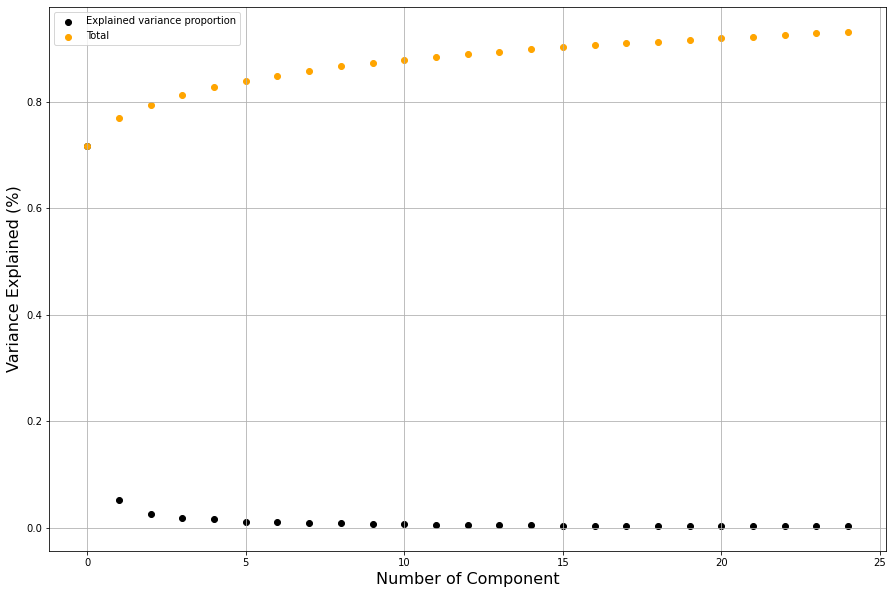

[0.71661778 0.05275803 0.02499367 0.01836901 0.01526855 0.0108568
 0.01049908 0.0090229  0.00834353 0.00651242 0.00600894 0.00537175
 0.00498627 0.00450925 0.00434435 0.00391738 0.00370435 0.00353249
 0.00339892 0.00328792 0.00314625 0.00311592 0.00300644 0.00296642
 0.00285009]


In [19]:
plt.figure(figsize=(15, 10))
comp_to_view = 25
#let's plot it
plot_xs = list(range(comp_to_view))


plt.scatter(plot_xs, pca.explained_variance_ratio_[:comp_to_view], color='black', label='Explained variance proportion')
plt.scatter(plot_xs, total[:comp_to_view],color='orange', label='Total')

plt.legend(loc=2)
plt.xlabel('Number of Component', size=16)
plt.ylabel('Variance Explained (%)', size=16)
#plt.hlines(0.,xmin=0, xmax=comp_to_view, colors = 'blue', linestyles='--')
plt.grid('minor')
plt.show()

print(pca.explained_variance_ratio_[:comp_to_view])

In [20]:
#initialize the pca

n_comp = 25
pca = PCA(n_components = n_comp, whiten=True, copy=True, random_state= 10)

#fit with random sample of _ observations
pca.fit(rd.sample(X_train,10000))


PCA(n_components=25, random_state=10, whiten=True)

In [21]:
## batchwise transformation of the 

reduced = []
batchsize = 2500
# 
for i in range(0, len(X_train), batchsize):
    if i == 0:
        reduced = pca.transform(X_train[i:i+batchsize])
        continue 
    
    reduced_batch = pca.transform(X_train[i:i+batchsize])
    reduced = np.concatenate((reduced, reduced_batch), axis =0)

X_train_pca = np.asarray(reduced)
n_obs = len(X_train_pca)

In [22]:
import matplotlib.image as mpimg
#function straight copied from
def plot_gallery(title, images, n_col, n_row, cmap_p=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        #print(vmax)
        plt.imshow((comp*255).astype(np.uint8),
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax 
                   #cmap = cmap_p
                   )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    return plt.show()

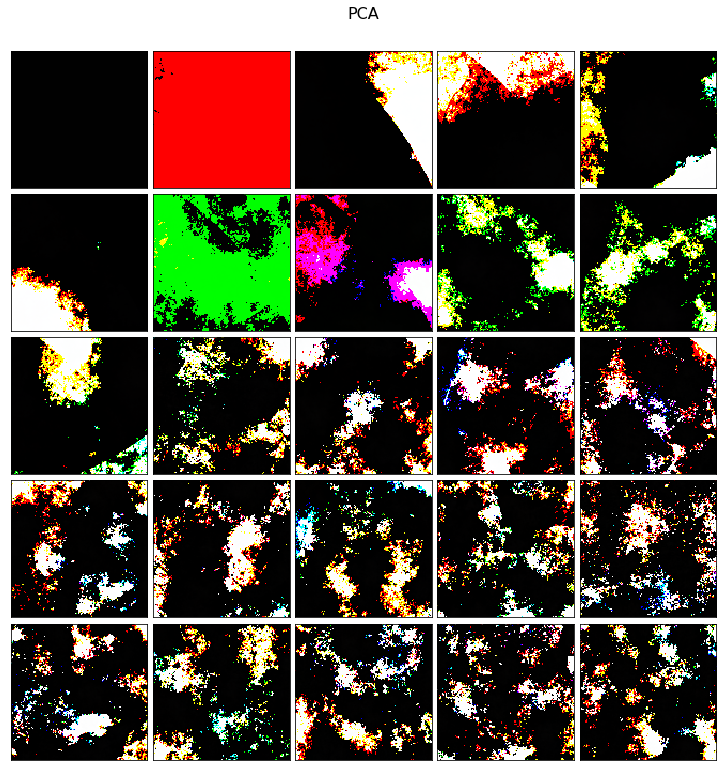

In [23]:
eigenimages = pca.components_.reshape(n_comp,128,128,4).copy()
plot_gallery("PCA", eigenimages[:,:,:,:3], n_col=5, n_row=5, cmap_p = plt.cm.viridis)

## Linear Model

In [24]:
lin_model = LinearRegression()
lin_model.fit(X_train_pca, y_train)

LinearRegression()

In [25]:
lin_model.score(X_train_pca, y_train)

0.045446507969605365

In [26]:
len(np.unique(X_train_pca))

23150

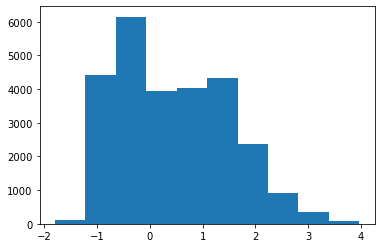

In [27]:
plt.hist((y_train))
plt.show()

## Random Forest

In [28]:
rf = RandomForestRegressor(n_estimators= 100, bootstrap = True)
rf.fit(X_train_pca, y_train)

RandomForestRegressor()

In [29]:
rf.score(X_train_pca, y_train)

0.6412984169913836

## Running Grid Search on Random Forest Regressor

Source and documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Tuning: 
- n_estimators: number of trees in the forest
- max_depth: maximum depth of the tree 
- max_features: number of features taken into account when splitting. 

In [30]:
hyper_n_list = [100]
hyper_depth_list = [1,2,3,4,5, 10,16,18,20,22,24,26, 30, 40, 50, 100, 200]
hyper_m_list = ["auto", "sqrt", "log2"]

In [31]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':hyper_n_list,
                              'max_depth': hyper_depth_list,
                              'max_features': hyper_m_list,
                            },cv=4, scoring="r2",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_train_pca,y_train)

Fitting 4 folds for each of 51 candidates, totalling 204 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.9min finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 16, 18, 20, 22, 24,
                                       26, 30, 40, 50, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100]},
             scoring='r2', verbose=1)

In [32]:
cv_df = pd.DataFrame(grid_search.cv_results_)

In [33]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,3.476907,0.080315,0.050285,0.008913,1,auto,100,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.037532,0.036034,0.036707,0.031035,0.035327,0.002534,49
1,1.054548,0.018739,0.045601,0.011222,1,sqrt,100,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.034890,0.034051,0.032036,0.034180,0.033789,0.001062,50
2,1.141982,0.093241,0.054448,0.014261,1,log2,100,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.032608,0.032279,0.030224,0.032235,0.031837,0.000942,51
3,5.679241,0.092354,0.034702,0.001712,2,auto,100,"{'max_depth': 2, 'max_features': 'auto', 'n_es...",0.083397,0.080751,0.082242,0.076800,0.080798,0.002491,46
4,1.671935,0.125227,0.040055,0.004824,2,sqrt,100,"{'max_depth': 2, 'max_features': 'sqrt', 'n_es...",0.070775,0.072285,0.066257,0.069403,0.069680,0.002224,47
5,1.223807,0.032149,0.033394,0.002696,2,log2,100,"{'max_depth': 2, 'max_features': 'log2', 'n_es...",0.067532,0.067058,0.064192,0.065847,0.066157,0.001290,48
6,6.804559,0.028006,0.041965,0.003082,3,auto,100,"{'max_depth': 3, 'max_features': 'auto', 'n_es...",0.134904,0.131019,0.134250,0.128133,0.132077,0.002710,43
7,2.036200,0.019643,0.038058,0.001814,3,sqrt,100,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.113897,0.116935,0.109909,0.113925,0.113667,0.002496,44
8,1.576304,0.023950,0.044683,0.001494,3,log2,100,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.103689,0.110475,0.104565,0.107145,0.106468,0.002639,45
9,8.402270,0.045521,0.045414,0.002316,4,auto,100,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.193975,0.192931,0.189958,0.184638,0.190375,0.003626,40


In [34]:
def hyperparam_plot2d(df, param, outcome, group_var = None):

    '''
    func: function to plot the performance of a parameter
    - df (dataframe): cross-validation grid search dataframe

    params have to be column names in DF
    - param (str): which parameter to asses
    - outcome (str): which outcome to find the max for
    - group_var (str): grouping variable (default None)
    '''

    group_var_list = np.unique(np.array(df[group_var]))
    plt.figure(figsize=(12,8))
    #print(np.argmax(np.asarray(df[outcome])))
    best_score = np.max(np.asarray(df[outcome]))
    best_score_param = np.asarray(df[param])[np.argmax(np.asarray(df[outcome]))]
    if group_var != None:
        best_score_group = np.asarray(df[group_var])[np.argmax(np.asarray(df[outcome]))]
        #print(best_score_group)

    if group_var == None:
        plt.plot(param,outcome,data = df)
        plt.xlabel(param)
        plt.ylabel(outcome)
        #plt.grid()
        plt.vlines(best_score_param, 0, np.max(np.asarray(df[outcome])+.05))
        plt.text(best_score_param,best_score - (best_score*.1),  f'Best parameter: {best_score_param} with score: {best_score}',size =12)
        plt.legend()
    else:
        for inst in group_var_list:
            plt.plot(param,outcome,label = inst, data = df[df[group_var]== inst])
            plt.xlabel(param)
            plt.ylabel(outcome)
            #plt.grid()
            plt.text(best_score_param,best_score - (best_score*.1),  f'Best parameter: {best_score_param} \n with score: {round(best_score,3)} \nin group:{best_score_group}', size = 12)
            plt.vlines(best_score_param, 0, best_score+.05)
            plt.legend(loc = 4)
            plt.ylim(bottom =0 )
    plt.grid()
    return plt.show()

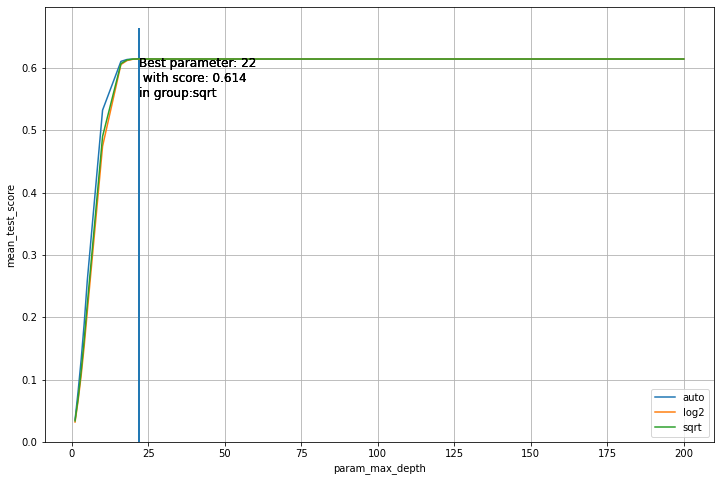

In [35]:
hyperparam_plot2d(cv_df, 'param_max_depth', 'mean_test_score', 'param_max_features')

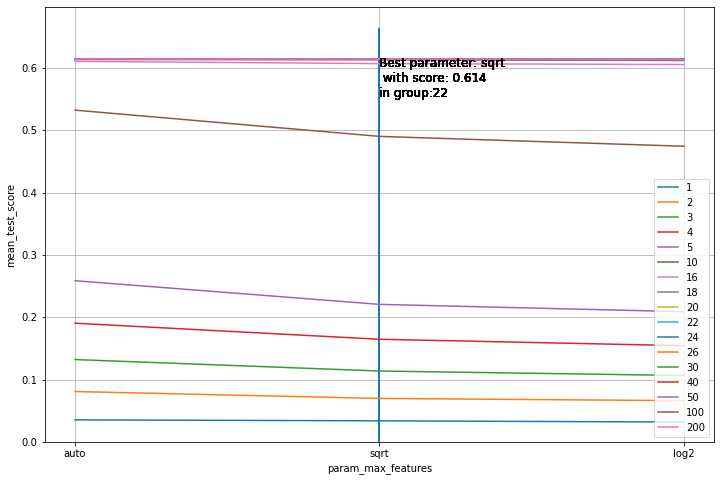

In [36]:
hyperparam_plot2d(cv_df, 'param_max_features' ,'mean_test_score','param_max_depth')

In [37]:
best_forest = grid_search.best_estimator_

## CNN 

### Prepare

In [38]:
from tensorflow import keras
import gc
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import applications

In [40]:
X_train_cnn = np.asarray(X_train).reshape(n_obs, 128, 128, 4)
#X_train_cnn

In [41]:
X_train_cnn = X_train_cnn[:,:,:,:3].astype('float32') # Taking out the fourth channel as ghe information is the same everywhere
y_train_cnn = np.asarray(y_train).astype('float32')

In [42]:
X_train1_cnn, X_val_cnn, y_train1_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train_cnn, test_size=0.10)

### Model 

In [43]:
# https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [44]:
cnn_satellite = Sequential()
cnn_satellite.add(Conv2D(32, kernel_size=(16, 16),activation='linear',input_shape=(128,128,3),padding='same'))
cnn_satellite.add(LeakyReLU(alpha=0.1))
cnn_satellite.add(MaxPooling2D((2, 2),padding='same'))
cnn_satellite.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
cnn_satellite.add(LeakyReLU(alpha=0.1))
cnn_satellite.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_satellite.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
cnn_satellite.add(LeakyReLU(alpha=0.1))                  
cnn_satellite.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_satellite.add(Flatten())
cnn_satellite.add(Dense(32, activation='linear'))
cnn_satellite.add(LeakyReLU(alpha=0.1))                  
cnn_satellite.add(Dense(1, activation='linear'))

gc.collect()

69556

In [45]:
cnn_satellite.compile(loss=keras.losses.mean_squared_error, 
                      optimizer=keras.optimizers.Adam(),
                      metrics=[coeff_determination])

In [46]:
cnn_satellite.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      24608     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

In [47]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
#os.environ['TORCH_HOME'] = '/workspace/cache'

In [12]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [20]:
gc.collect()

954

In [25]:
"""with strategy.scope():
    cnn_satellite = Sequential()
    cnn_satellite.add(Conv2D(32, kernel_size=(16, 16),activation='linear',input_shape=(256,256,3),padding='same'))
    cnn_satellite.add(LeakyReLU(alpha=0.1))
    cnn_satellite.add(MaxPooling2D((2, 2),padding='same'))
    cnn_satellite.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    cnn_satellite.add(LeakyReLU(alpha=0.1))
    cnn_satellite.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    cnn_satellite.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    cnn_satellite.add(LeakyReLU(alpha=0.1))                  
    cnn_satellite.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    cnn_satellite.add(Flatten())
    cnn_satellite.add(Dense(32, activation='linear'))
    cnn_satellite.add(LeakyReLU(alpha=0.1))                  
    cnn_satellite.add(Dense(1, activation='linear'))
    cnn_satellite.compile(loss=keras.losses.mean_squared_error, 
                      optimizer=keras.optimizers.Adam(),
                      metrics=[coeff_determination])"""

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [48]:
X_cnn_res50 = applications.resnet_v2.preprocess_input(
    X_train1_cnn)

In [51]:
## Hyperparameters

epochs = 2
batchsize = 50

In [ ]:
img

In [52]:
#fit and record the history 
cnn_history = cnn_satellite.fit(X_cnn_res50, 
                  y_train1_cnn, 
                  batch_size=batchsize, 
                  epochs=epochs, 
                  verbose=1
                  #validation_data=(X_val_cnn, y_val_cnn)
                                   )

Epoch 1/2
209/481 [============>.................] - ETA: 7:44 - loss: 1.0913 - coeff_determination: -0.0452

KeyboardInterrupt: 

In [ ]:
test_eval = cnn_satellite.evaluate(X_val_cnn, y_val_cnn, verbose=1)

In [ ]:
plt.plot([i for i in range(epochs)], cnn_history.history['val_coeff_determination'], color = 'grey')
plt.scatter([i for i in range(epochs)], cnn_history.history['val_coeff_determination'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation $R^2$')
plt.show()

## ResNet50

In [56]:
from tensorflow.keras import applications
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None
)
resnet.trainable = False
resnet.summary()

gc.collect()


inputs = keras.Input(shape=(128, 128, 3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = resnet(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='linear')(x)
#x = keras.layers.Dropout(.2)(x)
#x = keras.layers.LeakyReLU(alpha=0.1)(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation = 'linear')(x)

model = keras.Model(inputs, outputs)

## prep the dataset with to be passed to resnet
X_cnn_res50 = applications.resnet_v2.preprocess_input(
    X_train1_cnn)

#X_cnn_res50_val = applications.resnet_v2.preprocess_input(
#    X_train1_cnn)
model.compile(loss=keras.losses.mean_squared_error, 
            optimizer=keras.optimizers.Adam(),
            metrics=[coeff_determination])
resnet_history = model.fit(X_cnn_res50, 
          y_train1_cnn, 
          epochs=150,
          batch_size = 75 
          #,callbacks=...
          #,validation_data= (X_cnn_res50_val, y_val_cnn)
         )


Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
plt.plot([i for i in range(150)], resnet_history.history['coeff_determination'], color = 'grey')
plt.scatter([i for i in range(150)], resnet_history.history['coeff_determination'])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation $R^2$')
plt.show()

In [57]:
from sklearn.svm import SVR
svr = SVR()

In [58]:
svr.fit(X_train_pca, y_train_cnn)

SVR()

In [61]:
hyper_C_list = [1,5,10,50]
hyper_ep_list = [0.1,.5,1]

In [66]:
grid_search_svr = GridSearchCV(SVR(),
                           {
                              'C':hyper_C_list,
                              'epsilon': hyper_ep_list
                            },cv=4, scoring="r2",verbose=1,n_jobs=-1
                           )
grid_search_svr.fit(X_train_pca,y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.0min finished


GridSearchCV(cv=4, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10, 50], 'epsilon': [0.1, 0.5, 1]},
             scoring='r2', verbose=1)

In [67]:
cv_df_svr = pd.DataFrame(grid_search_svr.cv_results_)
cv_df_svr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,60.551660,0.091937,12.283337,0.038556,1,0.1,"{'C': 1, 'epsilon': 0.1}",0.435483,0.452893,0.436752,0.405068,0.432549,0.017287,10
1,35.045170,0.229190,6.636880,0.036922,1,0.5,"{'C': 1, 'epsilon': 0.5}",0.440356,0.451047,0.439908,0.414735,0.436512,0.013340,9
2,15.473558,0.168306,2.024671,0.028896,1,1,"{'C': 1, 'epsilon': 1}",0.352298,0.354343,0.351448,0.337537,0.348906,0.006648,12
3,61.992790,0.251574,11.583994,0.028086,5,0.1,"{'C': 5, 'epsilon': 0.1}",0.517168,0.535220,0.520249,0.489808,0.515611,0.016388,6
4,32.450626,0.146424,5.146074,0.059501,5,0.5,"{'C': 5, 'epsilon': 0.5}",0.520203,0.531746,0.523457,0.495560,0.517742,0.013480,5


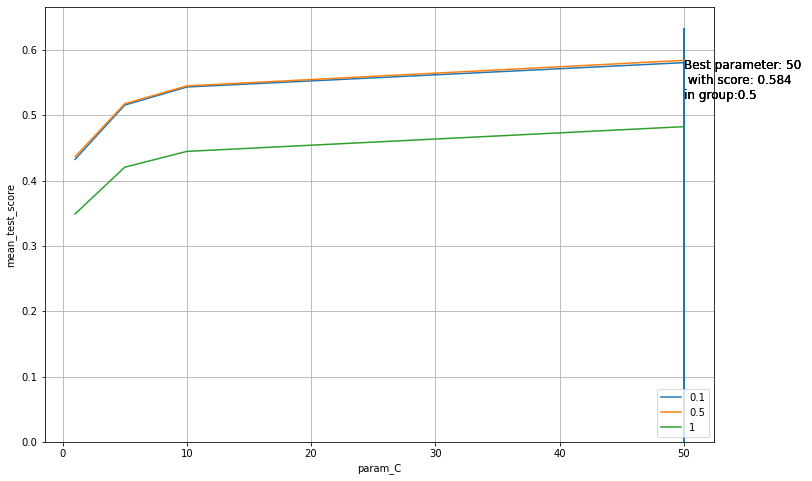

In [68]:
hyperparam_plot2d(cv_df_svr, 'param_C', 'mean_test_score', 'param_epsilon')